<a href="https://colab.research.google.com/github/KU-Gen-AI-2567/VAE-demo/blob/main/VAE_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VAE - 01418496

**สมาชิกกลุ่ม**

นายศิวกร ภาสว่าง 6410451423

นางสาว เเพรวรุ้ง พุดชะวา 6410451253

นางสาว มารีน่า มิทซุย 6410450222

หมู่ 200

ชุดข้อมูล : Anime Face Dataset

link download : https://www.kaggle.com/datasets/splcher/animefacedataset

In [19]:
import tensorflow as tf
import matplotlib.pyplot as plt
import kagglehub
import shutil
import os
import numpy as np
from PIL import Image
tf.__version__

'2.17.1'

## Setting to execute on Processor (GPU or CPU)

In [20]:
gpus = tf.config.list_physical_devices("GPU")
if len(gpus) > 0:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    print("Execute on GPU")
else:
    print("Execute on CPU")

Execute on GPU


## Download Dataset

In [21]:
# Download the dataset folder in latest version
if not "dataset" in os.listdir("."):
    path = kagglehub.dataset_download("splcher/animefacedataset")
    print("Path to dataset files:", path)
    shutil.move(path, "./dataset")
    print("Download Dataset Complete")
else:
    print("Download Dataset Already")

Download Dataset Already


## Prepossessing

In [22]:
from collections import Counter

# Check and count original image sizes
def check_image_sizes(directory):
    size_counter = Counter()
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(root, file)
                img = tf.keras.utils.load_img(img_path)
                size_counter[img.size] += 1
    for size, count in size_counter.items():
        print(f"Size: {size}, Count: {count}")

check_image_sizes("dataset/images")

Size: (88, 88), Count: 1337
Size: (97, 97), Count: 1406
Size: (91, 91), Count: 1447
Size: (67, 67), Count: 589
Size: (92, 92), Count: 1636
Size: (65, 65), Count: 593
Size: (96, 96), Count: 1556
Size: (124, 124), Count: 213
Size: (84, 84), Count: 1245
Size: (90, 90), Count: 1516
Size: (123, 123), Count: 191
Size: (101, 101), Count: 1285
Size: (48, 48), Count: 84
Size: (112, 112), Count: 581
Size: (134, 134), Count: 92
Size: (74, 74), Count: 801
Size: (62, 62), Count: 636
Size: (110, 110), Count: 681
Size: (99, 99), Count: 1439
Size: (83, 83), Count: 1028
Size: (104, 104), Count: 1200
Size: (115, 115), Count: 468
Size: (56, 56), Count: 412
Size: (85, 85), Count: 1272
Size: (89, 89), Count: 1360
Size: (57, 57), Count: 457
Size: (82, 82), Count: 1085
Size: (78, 78), Count: 853
Size: (55, 55), Count: 328
Size: (94, 94), Count: 1534
Size: (109, 109), Count: 760
Size: (70, 70), Count: 646
Size: (102, 102), Count: 1276
Size: (103, 103), Count: 1235
Size: (100, 100), Count: 1394
Size: (79, 79),

In [23]:
from tensorflow.keras import utils

IMAGE_SIZE = (64, 64) # 🤔
BATCH_SIZE = 128

train_data = utils.image_dataset_from_directory(
    "dataset/images",
    labels=None,
    color_mode="rgb", # 🤔
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

def preprocess(img):
    img = tf.cast(img, "float32") / 255.0 # 🤔
    return img

train_data = train_data.map(lambda x: preprocess(x))

Found 63565 files.


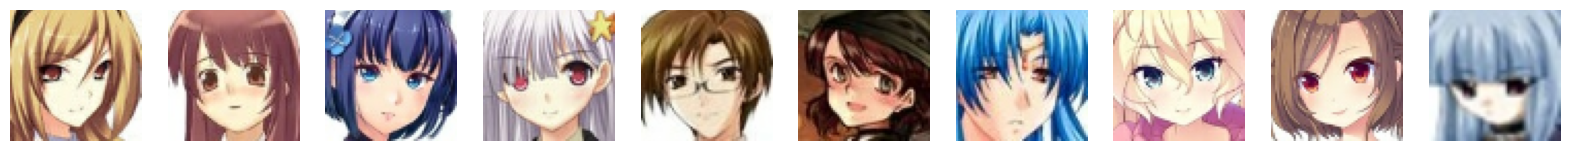

In [24]:
import matplotlib.pyplot as plt

def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    batch = batch[0] if isinstance(batch, tuple) else batch
    return batch.numpy()

def display(images, n=10, size=(20, 3), cmap="gray_r", as_type="float32"):
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)

    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    plt.show()

train_sample = sample_batch(train_data)
display(train_sample, cmap=None)

## Create Model

In [25]:
# code for creating model
from tensorflow.keras import layers, activations, models
import tensorflow.keras.backend as K

Z_DIM = 200

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5*z_log_var) * epsilon

encoder_input = layers.Input(shape=(64, 64, 3), name="EncoderInput")
x = layers.Conv2D(16, (3, 3), activation=activations.leaky_relu, padding="same", strides=2)(encoder_input)
x = layers.Conv2D(32, (3, 3), activation=activations.leaky_relu, padding="same", strides=2)(x)
x = layers.Conv2D(64, (3, 3), activation=activations.leaky_relu, padding="same", strides=2)(x)

shape_before_flatten = K.int_shape(x)[1:]

x = layers.Flatten()(x)
z_mean = layers.Dense(Z_DIM, name="z_mean")(x)
z_log_var = layers.Dense(Z_DIM, name="z_log_var")(x)

z = Sampling()([z_mean, z_log_var])

encoder_model = models.Model(encoder_input, [z_mean, z_log_var, z], name="EncoderModel")
encoder_model.summary()

Model: "EncoderModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ EncoderInput (InputLayer) │ (None, 64, 64, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 32, 32, 16)     │            448 │ EncoderInput[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 16, 16, 32)     │          4,640 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 8, 8, 64)       │         18,496 │ conv2d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 4096)           │              0 │ conv2d_10[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 200)            │        819,400 │ flatten_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 200)            │        819,400 │ flatten_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_2 (Sampling)     │ (None, 200)            │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,662,384 (6.34 MB)

 Trainable params: 1,662,384 (6.34 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
decoder_input = layers.Input(shape=(Z_DIM, ), name='Decoder Input')
x = layers.Dense(tf.math.reduce_prod(shape_before_flatten).numpy(), activation=activations.leaky_relu)(decoder_input)
x = layers.Reshape(shape_before_flatten)(x)
x = layers.Conv2DTranspose(64, (3, 3), activation=activations.leaky_relu, padding='same', strides=2)(x)
x = layers.Conv2DTranspose(32, (3, 3), activation=activations.leaky_relu, padding='same', strides=2)(x)
x = layers.Conv2DTranspose(16, (3, 3), activation=activations.leaky_relu, padding='same', strides=2)(x)
decoder_output = layers.Conv2D(3, (3, 3), activation=activations.sigmoid, padding='same')(x)

decoder_model = models.Model(decoder_input, decoder_output, name="DecoderModel")
decoder_model.summary()

Model: "DecoderModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Decoder Input (InputLayer)           │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4096)                │         823,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_2 (Reshape)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_6 (Conv2DTranspose) │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_7 (Conv2DTranspose) │ (None, 32, 32, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_8 (Conv2DTranspose) │ (None, 64, 64, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 64, 64, 3)           │             435 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 883,747 (3.37 MB)

 Trainable params: 883,747 (3.37 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
from tensorflow.keras import metrics, losses, optimizers

BETA = 2000

class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data, training=True)
            reconstruction_loss = tf.reduce_mean(BETA * losses.MSE(data, reconstruction))
            kl_loss = tf.reduce_mean(tf.reduce_sum(-0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)), axis=1))
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(BETA * losses.MSE(data, reconstruction))
        kl_loss = tf.reduce_mean(tf.reduce_sum(-0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)), axis=1))
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

vae = VAE(encoder_model, decoder_model)
vae.compile(optimizer=optimizers.AdamW())

## Train Model

In [28]:
# code for training model
from tensorflow.keras import callbacks

EPOCHS = 10

class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.decoder(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()

        for i in range(self.num_img):
            utils.array_to_img(generated_images[i])

vae.fit(
    train_data,
    epochs=EPOCHS,
    callbacks=[ImageGenerator(num_img=10, latent_dim=Z_DIM)],
)

Epoch 1/10
497/497 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step - kl_loss: 7.5774 - loss: 116.2650 - reconstruction_loss: 108.6876
Epoch 2/10
497/497 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - kl_loss: 12.2302 - loss: 81.5281 - reconstruction_loss: 69.2979
Epoch 3/10
497/497 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - kl_loss: 12.8750 - loss: 78.0877 - reconstruction_loss: 65.2128
Epoch 4/10
497/497 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - kl_loss: 13.1853 - loss: 76.9092 - reconstruction_loss: 63.7238
Epoch 5/10
497/497 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - kl_loss: 13.4889 - loss: 76.1968 - reconstruction_loss: 62.7078
Epoch 6/10
497/497 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - kl_loss: 13.6740 - loss: 75.8203 - reconstruction_loss: 62.1463
Epoch 7/10
497/497 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - kl_loss: 13.7951 - loss: 75.5597 - reconstruction_loss: 61.7645
Epoch 8/10
497/497 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - kl_loss: 13.8525 - loss: 75.3372 - reconstruction_loss: 61.4847
Epoch 9/10
497/497 ━━━━━━━━━━━━━━━━━━━━

## Visulization

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step  
Examples


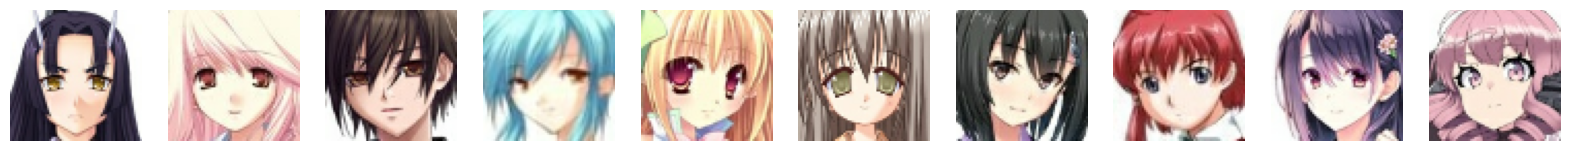

Reconstructions


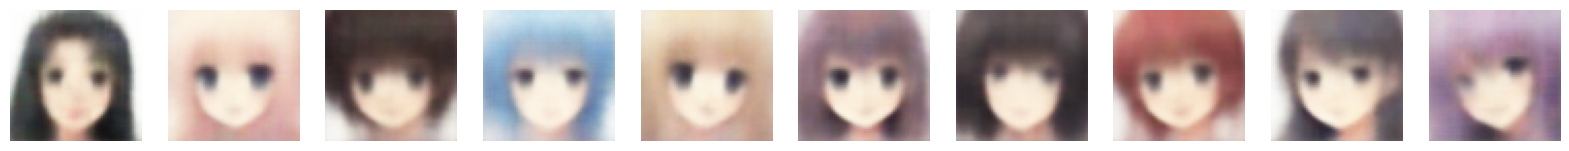

In [29]:
# code for visulization 1
batches_to_predict = 1
example_images = np.array(list(train_data.take(batches_to_predict).get_single_element()))
z_mean, z_log_var, reconstructions = vae.predict(example_images)

print("Examples")
display(example_images)

print("Reconstructions")
display(reconstructions)

In [30]:
# code for visulization 2

## Member Participation

รายละเอียดการมีส่วนร่วม